# Youth Crime Model

In this file, a model is developed to simulate youth crime in a city. The model takes into account various factors that were found in literature, such as influences from peers, family background, and school status. The model uses real-world data from Arnhem, including demographic information. The model can be used to analyze youth crime patterns. 

This model is a basis for further development and can be extended with more detailed data and additional factors influencing youth crime.

In [1]:
import random 
import numpy as np
import mesa
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

## Get Arnhem Data

First, it is important to note that we are using Arnhem data as this example. As we want the model to be based on Arnhem, we use their data. If the user wants to use another city, they should replace the Arnhem data with their own data.

We make a dictionary that contains the population proportion of each neighborhood in Arnhem. This will be used later to generate the population distribution for the model.

In [2]:
# Use the provided CSVs (semicolon-separated). Adjust paths if needed.
pop_path = 'data/Bevolking - Centrum.csv'         # population by wijk
map_path = 'data/dataset kaart gemeente.csv'     # wijk metadata

pop_df = pd.read_csv(pop_path, sep=';', index_col=False)
map_df = pd.read_csv(map_path, sep=';', encoding='utf-8', low_memory=False)

arnhem_total = float(pop_df.loc[pop_df["buurt of wijk / dimensie"].str.lower()=="arnhem", "Waarde"].iloc[0])

wijken = pop_df[pop_df["buurt of wijk / dimensie"].str.lower()!="arnhem"][["buurt of wijk / dimensie","Waarde"]].copy()
wijken["Waarde"] = pd.to_numeric(wijken["Waarde"], errors="coerce")
wijken["share"] = wijken["Waarde"] / arnhem_total

wijk_share_dict = dict(zip(wijken["buurt of wijk / dimensie"], wijken["share"]))
del wijk_share_dict['Onbekend binnen Arnhem']
print(f'These are the proportions per neightborhood in Arnhem: {wijk_share_dict}')


These are the proportions per neightborhood in Arnhem: {'Centrum': 0.042078842462719625, 'Spijkerkwartier': 0.04039568876421084, 'Arnhemse Broek': 0.04479551159013731, 'Presikhaaf-West': 0.05253211280082681, 'Presikhaaf-Oost': 0.04553373689650081, 'St.Marten/Sonsbeek': 0.03375166100693932, 'Klarendal': 0.042698951720064965, 'Velperweg e.o.': 0.05507160785471726, 'Alteveer/Cranevelt': 0.0206998375904326, 'Geitenkamp': 0.022471578325705004, 'Monnikenhuizen': 0.026192233869777055, 'Burgemeesterswijk/Hoogkamp': 0.04630149121511885, 'Schaarsbergen e.o.': 0.01411486785767016, 'Heijenoord/Lombok': 0.022648752399232246, 'Klingelbeek e.o.': 0.008445297504798464, 'Malburgen-West': 0.028465967813376642, 'Malburgen-Oost (Noord)': 0.03779713568581131, 'Malburgen-Oost (Zuid)': 0.05468773069540824, 'Vredenburg/Kronenburg': 0.05176435848220877, 'Elden': 0.01762882031596043, 'Elderveld': 0.051498597371917906, 'De Laar': 0.07148973866824154, 'Rijkerswoerd': 0.0724937250848959, 'Schuytgraaf': 0.096412225

We also want to know the amount of people living in Arnhem. 

In [3]:
arn_df = pop_df[pop_df['buurt of wijk / dimensie'] == 'Arnhem']
display(arn_df.head())

people_arnhem = int(arn_df['Waarde'].iloc[0])
print(f'The amount of people in Arnhem is {people_arnhem}')

,Mosaic,Tegel,Indicator,Eenheid,Periode,buurt of wijk / dimensie,Waarde,Bron,Omschrijving
1,Bevolking (buurt/wijk),Bevolking,bevolking,aantal personen,2025,Arnhem,169325,Basisregistratie personen (BRP); gemeente Arnhem,Aantal inwoners in een gebied naar kenmerk\n- ...
3,Bevolking (buurt/wijk),Bevolking,bevolking,aantal personen,2025,Arnhem,169325,Basisregistratie personen (BRP); gemeente Arnhem,Aantal inwoners in een gebied naar kenmerk\n- ...
5,Bevolking (buurt/wijk),Bevolking,bevolking,aantal personen,2025,Arnhem,169325,Basisregistratie personen (BRP); gemeente Arnhem,Aantal inwoners in een gebied naar kenmerk\n- ...
7,Bevolking (buurt/wijk),Bevolking,bevolking,aantal personen,2025,Arnhem,169325,Basisregistratie personen (BRP); gemeente Arnhem,Aantal inwoners in een gebied naar kenmerk\n- ...
9,Bevolking (buurt/wijk),Bevolking,bevolking,aantal personen,2025,Arnhem,169325,Basisregistratie personen (BRP); gemeente Arnhem,Aantal inwoners in een gebied naar kenmerk\n- ...


The amount of people in Arnhem is 169325


We also want to know how many youths there are in Arnhem. That is done by taking the total population of Arnhem and multiplying it by the percentages of youths in the population. In this dataset we get the percentages of youths in different age groups, which we sum to get the total percentage of youths.

In [4]:
age_path = 'data/Bevolking naar leeftijdsklassen - Arnhem.csv'
age_df = pd.read_csv(age_path, sep=';', index_col=False)
age_df = age_df[age_df['Periode'] == 2026]
ages = ['bevolking (%), 4 tot 12', 'bevolking (%), 12 tot 18', 'bevolking (%), 18 tot 25']

needed_ages = age_df[age_df['Indicator'].isin(ages)]
display(needed_ages)
percentage_youth_4_24 = needed_ages['Waarde'].str.replace(',', '.', regex=False).astype(float).sum()/100
print(f'The amount of people between age 4-24 is {percentage_youth_4_24}')

,Mosaic,Tegel,Indicator,Eenheid,Periode,buurt of wijk / dimensie,Waarde,Bron,Omschrijving
4,Bevolking,Bevolking naar leeftijdsklassen,"bevolking (%), 4 tot 12",%,2026,Arnhem,"7,8",Basisregistratie personen (BRP); gemeente Arnhem,inwoners in een gebied: aandeel per kenmerk\n\...
6,Bevolking,Bevolking naar leeftijdsklassen,"bevolking (%), 12 tot 18",%,2026,Arnhem,"6,5",Basisregistratie personen (BRP); gemeente Arnhem,inwoners in een gebied: aandeel per kenmerk\n\...
8,Bevolking,Bevolking naar leeftijdsklassen,"bevolking (%), 18 tot 25",%,2026,Arnhem,"9,8",Basisregistratie personen (BRP); gemeente Arnhem,inwoners in een gebied: aandeel per kenmerk\n\...


The amount of people between age 4-24 is 0.24100000000000002


## Helper Functions

First, we make two functions that can be used in the model. The first function takes a value and makes sure it is between 0 and 1. The second function takes Beta distribution parameters and returns a random value from that distribution. These functions can be used later in the model.

In [5]:
def min_max_01(x: float) -> float:
    return max(0.0, min(1.0, x))

def beta_from_mean_k(mean, k):
    a = mean * k
    b = (1-mean) * k
    return float(np.random.beta(a, b))

## Agents

Then the agents are defined. Each agent has several attributes which are initialized based on the data and literature. The most important Agent is the YouthAgent, which represents a youth in the city. The YouthAgent can commit crimes based on various factors such as peer influence, family issues, and school status. The YouthAgent can drop out of school, which also influences their likelihood of committing crimes. Other agents include the SchoolAgent, and HouseholdAgent, each with their own attributes. These agents have a supporting role in the model, where they are connected to the YouthAgent and influence their behavior.

In [6]:
class Household(mesa.Agent):
    """A household agent representing family environment."""
    def __init__(self, model, neighbourhood_id: str = None):
        super().__init__(model)
        self.family_support_level = beta_from_mean_k(0.75, 12) # 0..1
        self.issues = beta_from_mean_k(0.25, 10) # 0..1
        self.neighbourhood_id = neighbourhood_id

In [7]:
class SchoolAgent(mesa.Agent):
    """A school agent representing educational environment."""
    def __init__(self, model, neighbourhood_id: str):
        super().__init__(model)
        self.quality_level = beta_from_mean_k(0.75, 12) # 0..1
        self.neighbourhood_id = neighbourhood_id
        self.students = []

    def enroll(self, youth):
        if youth not in self.students:
            self.students.append(youth)

    def unenroll(self, youth):
        if youth in self.students:
            self.students.remove(youth)

In [8]:
class YouthAgent(mesa.Agent):
    """An agent representing a youth with risk propensity and peer influence."""
    def __init__(self, model, age, neighbourhood_id, household, friend_group, school=None, school_status='pre_school'):
        super().__init__(model)

        self.age = age
        self.neighbourhood_id = neighbourhood_id
        self.household = household
        self.friend_group = friend_group
        self.school = None

        # If age already >= 12, assign & enroll in local school on creation
        if age >= 12 and school is not None:
            self.school = school
            self.school.enroll(self)
            self.school_status = 'enrolled'
        else:
            # pre-school children (age 4..11)
            self.school_status = 'pre_school'

        # Individual traits / states
        self.crime_involvement = beta_from_mean_k(0.067, 3)

        self.criminalrecord = 0

        self.edu_performance = beta_from_mean_k(0.75, 12) # 0..1
        self.edu_motivation = beta_from_mean_k(0.75, 12) # 0..1

        self.family_support = self.household.family_support_level # 0..1
        self.mental_health = (self.family_support + (1-self.household.issues))/2

        self.job_chance = beta_from_mean_k(0.75, 12) # 0..1
        self.criminal_capital = beta_from_mean_k(0.75, 12) # 0..1
        self.job_status = random.choice(['unemployed', 'employed'])

        # Inertia: prevents instant dropout
        self.dropout_risk_streak = 0

        # For peer "recent crime" signal (still used for crime, not for dropout)
        self.last_offended = 0

    def peer_stats(self):
        friends = [a for a in self.friend_group if isinstance(a, YouthAgent)]
        if not friends:
            return 0.0, 0.0
        peer_recent_crime = float(np.mean([f.last_offended for f in friends]))
        peer_dropout_share = float(np.mean([1.0 if f.school_status == 'dropped_out' else 0.0 for f in friends]))
        return peer_recent_crime, peer_dropout_share

    def step(self):
        p = self.model.params
        peer_recent_crime, peer_dropout_share = self.peer_stats()

        # -------------------------
        # 1) Crime
        # -------------------------
        crime_risk = float(np.mean([
            self.crime_involvement,
            peer_recent_crime,
            self.criminal_capital,
            self.mental_health,
            1.0 - self.family_support,
            1.0 if self.school_status == 'dropped_out' else 0.0,
        ]))
        p_offend = min_max_01(p["base_offend_halfyear"] * (0.5 + crime_risk))

        offended = 1 if random.random() < p_offend else 0
        self.last_offended = offended

        if offended:
            self.criminalrecord += 1
            self.job_chance = min_max_01(self.job_chance - p["job_penalty_per_offense"])
            self.crime_involvement = min_max_01(self.crime_involvement + p["crime_involvement_drift"])
            self.criminal_capital = min_max_01(self.criminal_capital + p["criminal_capital_gain"])

        # -------------------------
        # 2) Education updates
        # -------------------------
        if self.school_status in ['pre_school', 'enrolled', 'at_risk']:
            self.edu_performance = min_max_01(
                self.edu_performance
                + p["perf_gain"] * self.edu_motivation
                + p["perf_gain"] * self.family_support
                - p["perf_loss"] * self.mental_health
                - p["perf_loss"] * offended,
            )

            self.edu_motivation = min_max_01(
                self.edu_motivation
                + p["mot_gain"] * self.job_chance
                + p["mot_gain"] * self.family_support
                - p["mot_loss"] * self.mental_health
                - p["mot_loss"] * offended,
            )

            self.job_chance = min_max_01(
                self.job_chance 
                + p["job_increase_if_in_school"]
            )

        # -------------------------
        # 3) Dropout
        # Only run for enrolled / at_risk students; pre-schoolers cannot drop out
        # -------------------------
        if self.school_status in ['enrolled', 'at_risk']:

            # pushed-out risk only:
            # low performance + low motivation + mental health + low support + peers dropping out
            pushed_risk = float(np.mean([
                1.0 - self.edu_performance,
                1.0 - self.edu_motivation,
                self.mental_health,
                1.0 - self.family_support,
                peer_dropout_share,
            ]))

            p_dropout = min_max_01(p["base_dropout_halfyear"] * (0.5 + pushed_risk))

            if not (p["dropout_age_min"] <= self.age <= p["dropout_age_max"]):
                p_dropout = 0.0

            if random.random() < p_dropout:
                self.dropout_risk_streak += 1
            else:
                self.dropout_risk_streak = max(0, self.dropout_risk_streak - 1)

            if self.dropout_risk_streak >= p["streak_to_at_risk"]:
                self.school_status = 'at_risk'
            if self.dropout_risk_streak >= p["streak_to_dropout"]:
                self.school_status = 'dropped_out'

        # -------------------------
        # 4) Completion & jobs
        # -------------------------
        if self.age > 17 and self.school_status == 'enrolled' and self.edu_performance >= p["completion_perf_threshold"]:
            self.school_status = 'completed'
            self.job_chance = min_max_01(self.job_chance + p["job_bonus_on_completion"])

        if self.school_status == 'completed' and self.job_status == 'unemployed':
            if random.random() < self.job_chance:
                self.job_status = 'employed'

        # -------------------------
        # 5) Age / enrollment on turning 12 / exit
        # -------------------------
        prev_age = self.age
        self.age += 0.5

        # If agent crosses into school-age (12), enroll and assign friends
        if prev_age < 12 <= self.age and self.school is None:
            school_to_join = self.model.sample_school_for_neighbourhood(self.neighbourhood_id)
            if school_to_join is not None:
                self.school = school_to_join
                self.school.enroll(self)
            self.school_status = 'enrolled'
            # assign friends for this newly enrolled agent (school + neighbourhood)
            self.model.assign_friend_groups(agents=[self])

        if self.age >= 24:
            if self.school is not None:
                self.school.unenroll(self)
            self.remove()
            return

## Model

Finally, the model is defined. The model initializes the population based on the Arnhem data and creates the agents. The model also defines the step function, which is called at each time step of the simulation. In the step function, each YouthAgent decides whether to commit a crime based on their attributes and influences from other agents. The model keeps track of the total number of crimes committed and other statistics that can be analyzed after the simulation runs.

In [9]:
class YouthCrimeModel(mesa.Model):
    def __init__(self, N_initial, N_yearly, neighbourhood_proportions=None):
        super().__init__()
        self.num_agents = N_initial
        self.N_yearly = N_yearly
        # Accept neighbourhood proportions (dict or None)
        self.neighbourhood_proportions = neighbourhood_proportions

        if self.neighbourhood_proportions:
            self.neigh_names = list(self.neighbourhood_proportions.keys())
            probs = np.array([self.neighbourhood_proportions[n] for n in self.neigh_names], dtype=float)
            self.neigh_probs = probs / probs.sum()  # normalize just in case
        else:
            self.neigh_names = None
            self.neigh_probs = None

        # Minimal, interpretable parameters
        self.params = {
            # Half-year hazards (step=0.5 years)
            "base_dropout_halfyear": 0.02,   # main knob for pushed-out dropout
            "base_offend_halfyear": 0.06,

            # Education dynamics
            "perf_gain": 0.03,
            "perf_loss": 0.03,
            "mot_gain": 0.02,
            "mot_loss": 0.02,

            # simple per-step bonus while enrolled (small)
            "job_increase_if_in_school": 0.005,

            # Crime/job links (optional)
            "job_penalty_per_offense": 0.05,
            "crime_involvement_drift": 0.01,
            "criminal_capital_gain": 0.02,

            # Dropout inertia
            "streak_to_at_risk": 2,
            "streak_to_dropout": 4,

            # Age window where dropout risk is allowed
            "dropout_age_min": 12,
            "dropout_age_max": 24,

            # Completion
            "completion_perf_threshold": 0.60,
            "job_bonus_on_completion": 0.20,
        }

        self.datacollector = mesa.DataCollector(
            model_reporters={
                "Average Crime Involvement": lambda m: np.mean([a.crime_involvement for a in m.agents if isinstance(a, YouthAgent)]),
                "Average Edu Motivation": lambda m: np.mean([a.edu_motivation for a in m.agents if isinstance(a, YouthAgent)]),
                "Average Edu Performance": lambda m: np.mean([a.edu_performance for a in m.agents if isinstance(a, YouthAgent)]),
                "Average Job Chance": lambda m: np.mean([a.job_chance for a in m.agents if isinstance(a, YouthAgent)]),
                "Drop out Rate": lambda m: np.mean([1 if a.school_status == 'dropped_out' else 0 for a in m.agents if isinstance(a, YouthAgent)]),
            },
            agent_reporters={
                "Age": lambda a: a.age if isinstance(a, YouthAgent) else None,
                "Crime Involvement": "crime_involvement",
                "Criminal record": "criminalrecord",
                "Edu Motivation": "edu_motivation",
                "Edu Performance": "edu_performance",
                "Job Chance": "job_chance",
                "Job Status": "job_status",
                "School status": "school_status",
                "Dropout streak": "dropout_risk_streak",
            }
        )

        # Create households (assign neighbourhoods to households)
        self.households = [Household(self, neighbourhood_id=self.sample_neighbourhood()) for _ in range(max(1, N_initial // 3))]

        # Create schools per neighbourhood and index them
        self.schools = []
        self.schools_by_neigh = defaultdict(list)
        if self.neigh_names is not None:
            for n in self.neigh_names:
                s = SchoolAgent(self, neighbourhood_id=n)
                self.schools.append(s)
                self.schools_by_neigh[n].append(s)
        else:
            # fallback: create a few generic schools
            for i in range(3):
                s = SchoolAgent(self, neighbourhood_id=str(i))
                self.schools.append(s)
                self.schools_by_neigh[str(i)].append(s)

        # helper to pick a school for a neighbourhood
        self.sample_school_for_neighbourhood = lambda nid: (random.choice(self.schools_by_neigh[nid]) if nid in self.schools_by_neigh and self.schools_by_neigh[nid] else (random.choice(self.schools) if self.schools else None))

        # Create initial youth distributed by neighbourhood_proportions if provided
        for _ in range(self.num_agents):
            nid = self.sample_neighbourhood()
            age = random.randint(4, 24)  # start from age 4
            assigned_school = self.sample_school_for_neighbourhood(nid) if age >= 12 else None
            YouthAgent(
                self,
                age=age,
                neighbourhood_id=nid,
                household=random.choice(self.households),
                friend_group=[],
                school=assigned_school,
            )

        # Assign friends using school+neighbour logic
        self.assign_friend_groups()

        # Initial dropout share (~4.6%) - only among currently enrolled youths
        youths_enrolled = [a for a in self.agents if isinstance(a, YouthAgent) and a.school_status == 'enrolled']
        initial_k = int(0.046 * len(youths_enrolled))
        if initial_k > 0 and youths_enrolled:
            for agent in random.sample(youths_enrolled, k=initial_k):
                agent.school_status = 'dropped_out'

    def assign_friend_groups(self, k_school=4, k_neigh=1, agents=None):
        """Assign each youth up to k_school friends from their school and up to k_neigh from their neighbourhood.
        If agents is None, assign for all youths; if agents is a list, assign for those agents but use full youth pool for neighbourhood picks."""
        all_youths = [a for a in self.agents if isinstance(a, YouthAgent)]
        if agents is None:
            targets = all_youths
        else:
            targets = agents

        for agent in targets:
            # If agent has a school: prefer school friends (up to k_school) + some neighbourhood friends (k_neigh)
            if agent.school is not None:
                school_pool = [s for s in (agent.school.students if agent.school else []) if s is not agent]
                school_friends = random.sample(school_pool, k=min(k_school, len(school_pool))) if school_pool else []

                neigh_pool = [y for y in all_youths if y is not agent and y not in school_friends and y.neighbourhood_id == agent.neighbourhood_id]
                neigh_friends = random.sample(neigh_pool, k=min(k_neigh, len(neigh_pool))) if neigh_pool else []
                agent.friend_group = school_friends + neigh_friends
            else:
                # No school yet: pick up to 5 friends from the neighbourhood
                neigh_pool = [y for y in all_youths if y is not agent and y.neighbourhood_id == agent.neighbourhood_id]
                neigh_friends = random.sample(neigh_pool, k=min(5, len(neigh_pool))) if neigh_pool else []
                agent.friend_group = neigh_friends

    # Helper: sample neighbourhood id according to proportions
    def sample_neighbourhood(self):
        if self.neigh_names is not None:
            return str(np.random.choice(self.neigh_names, p=self.neigh_probs))
        else:
            return random.randint(0, 5)

    def step(self):
        self.datacollector.collect(self)
        self.agents.do('step')

        # Add new youth once per year (2 steps because step = 0.5 years) starting at age 4
        if (self.steps % 2) == 0 and self.N_yearly > 0:
            new_agents = []
            for _ in range(self.N_yearly):
                nid = self.sample_neighbourhood()
                a = YouthAgent(
                    self,
                    age=4,
                    neighbourhood_id=nid,
                    household=random.choice(self.households),
                    friend_group=[],
                    school=None,
                    school_status='pre_school'
                )
                new_agents.append(a)
            # assign friends for the new agents (school friends will be empty until they enroll at 12)
            self.assign_friend_groups(agents=new_agents)


## Running the total model

Now, we can run the model for a certain number of steps and analyze the results. We can visualize the total number of crimes committed over time and see how different factors influence youth crime in the city. This can help in understanding the dynamics of youth crime and in developing strategies to reduce it.

In [10]:
# Run the model

# Use computed neighbourhood_proportions when instantiating the model
# Amount of youths in Arnhem 

num_agents = int(people_arnhem * percentage_youth_4_24)
print(f'The amount of youth in Arnhem {num_agents}')
model = YouthCrimeModel(num_agents, 1000, neighbourhood_proportions=wijk_share_dict)
for i in range(50):
    model.step()

model_data = model.datacollector.get_model_vars_dataframe()
agent_data = model.datacollector.get_agent_vars_dataframe()

The amount of youth in Arnhem 40807


In [14]:
agent_data.xs(40000, level='AgentID')


,Age,Crime Involvement,Criminal record,Edu Motivation,Edu Performance,Job Chance,Job Status,School status,Dropout streak
Step,,,,,,,,,
1,18.0,0.000084,0.0,0.885495,0.957437,0.92677,unemployed,enrolled,0.0
2,18.5,0.000084,0.0,0.900943,0.979371,1.00000,employed,completed,0.0
3,19.0,0.000084,0.0,0.900943,0.979371,1.00000,employed,completed,0.0
4,19.5,0.000084,0.0,0.900943,0.979371,1.00000,employed,completed,0.0
5,20.0,0.000084,0.0,0.900943,0.979371,1.00000,employed,completed,0.0
6,20.5,0.000084,0.0,0.900943,0.979371,1.00000,employed,completed,0.0
7,21.0,0.000084,0.0,0.900943,0.979371,1.00000,employed,completed,0.0
8,21.5,0.000084,0.0,0.900943,0.979371,1.00000,employed,completed,0.0
9,22.0,0.000084,0.0,0.900943,0.979371,1.00000,employed,completed,0.0


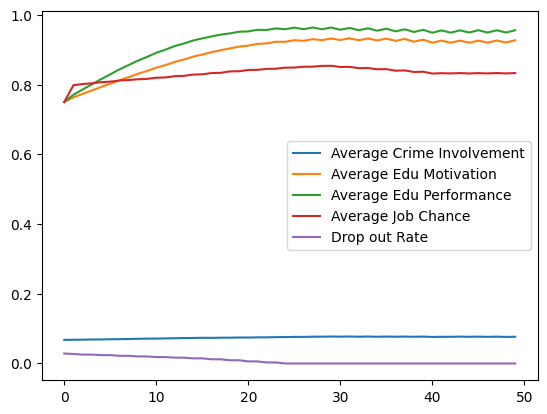

In [12]:
model_data.plot()
plt.show()

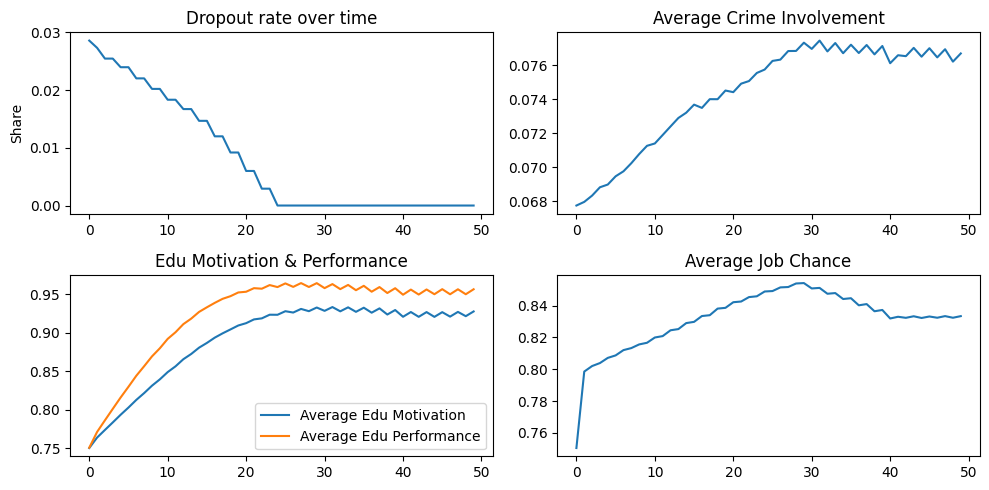

In [19]:
# Visualization: requested plots
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

md = model_data

fig, axs = plt.subplots(2, 2, figsize=(10, 5))

# 1) Dropout over time
md['Drop out Rate'].plot(ax=axs[0,0])
axs[0,0].set_title('Dropout rate over time')
axs[0,0].set_ylabel('Share')

# 2) Average crime involvement
md['Average Crime Involvement'].plot(ax=axs[0,1])
axs[0,1].set_title('Average Crime Involvement')

# 3) Edu motivation & edu performance
md[['Average Edu Motivation','Average Edu Performance']].plot(ax=axs[1,0])
axs[1,0].set_title('Edu Motivation & Performance')

# 4) Average job chance
md['Average Job Chance'].plot(ax=axs[1,1])
axs[1,1].set_title('Average Job Chance')

# # 5) Per-neighbourhood dropout rate (final snapshot)
# neigh = defaultdict(list)
# for a in getattr(model, 'agents', []):
#     try:
#         if isinstance(a, YouthAgent):
#             neigh[a.neighbourhood_id].append(1 if a.school_status == 'dropped_out' else 0)
#     except Exception:
#         pass
# neigh_rate = {k: (sum(v)/len(v) if len(v)>0 else 0.0) for k,v in neigh.items()}
# if neigh_rate:
#     keys = list(neigh_rate.keys())
#     vals = [neigh_rate[k] for k in keys]
#     axs[2,0].bar(keys, vals)
#     axs[2,0].set_title('Per-neighbourhood dropout rate (final)')
#     axs[2,0].tick_params(axis='x', rotation=45)
# else:
#     axs[2,0].text(0.5, 0.5, 'No neighbourhood data available', ha='center')

# # hide unused subplot
# axs[2,1].axis('off')

plt.tight_layout()
plt.show()